# Analysis House Price

## Introduction

The purpose is to help people in exploring better facilities around their neighborhood. For ease of accessing to Cafe, School, Super market, medical shops, grocery shops, mall, theatre, hospital, like minded people, etc. It will help people making smart and efficient decision on selecting great neighborhood out of numbers of other neighborhoods in North Yoth, Toronto.

## Data



- Neighborhood sections can be webscraped from Wikipedia.
- Neighborhood coordinates can be acquired through Google Maps
- Category of businesses nearby can be acquired through Foursquare API


The concept of the project is as follows. We first list out every neighborhood in the city. Then, we use their coordinates to explore businesses in that neighborhood and retrieve the type of business they are. Then we will cluster those results by observing the density of those facilities in a given neighborhood.

In [59]:
import pandas as pd
import requests
import numpy as np
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
import geocoder
from bs4 import BeautifulSoup

Wiki url

In [7]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')

Crawling

In [8]:
table_post = soup.find('table')
fields = table_post.find_all('td')

postcode = []
borough = []
neighbourhood = []

for i in range(0, len(fields), 3):
    postcode.append(fields[i].text.strip())
    borough.append(fields[i+1].text.strip())
    neighbourhood.append(fields[i+2].text.strip())
        
df_pc = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()
df_pc.columns = ['Postcode', 'Borough', 'Neighbourhood']
df_pc.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Combined postcode

In [9]:
df_pcn = df_pc.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df_pcn.columns = ['Postcode', 'Borough', 'Neighbourhood']

Replace nan

In [10]:
df_pcn['Borough'].replace('Not assigned', np.nan, inplace=True)
df_pcn.dropna(subset=['Borough'], inplace=True)

In [11]:
df_pcn.shape

(103, 3)

In [13]:
df_pcn.describe()

,Postcode,Borough,Neighbourhood
count,103,103,103
unique,103,10,98
top,M5R,North York,Downsview
freq,1,24,4


In [51]:
df_2.describe()

,Postcode,Borough,Neighbourhood
count,103,103,103
unique,103,10,98
top,M5R,North York,Downsview
freq,1,24,4


In [14]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.columns = ['Postcode', 'Latitude', 'Longitude']

In [22]:
df_pos = pd.merge(df_pcn, df_geo, on=['Postcode'], how='inner')
df_tor = df_pos[['Borough', 'Neighbourhood', 'Postcode', 'Latitude', 'Longitude']].copy()


In [35]:
address = 'North York, Canada'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the North York are 43.7543263, -79.44911696639593.


In [66]:
# create map of 'North York' using latitude and longitude values
map_NY = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_NY)  
    
map_NY

In [36]:
# @hiddel_cell
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [37]:
radius = 300 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [42]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups'],
      dtype='object')

In [43]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [44]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,No Leak Plumbing,"[{'id': '5454144b498ec1f095bff2f2', 'name': 'C...",43.753078,-79.448959
2,Crave Restaurant,"[{'id': '4bf58dd8d48988d14c941735', 'name': 'W...",43.753133,-79.450378
3,Domino's Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.753127,-79.450926


In [45]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,No Leak Plumbing,Construction & Landscaping,43.753078,-79.448959
2,Crave Restaurant,Wings Joint,43.753133,-79.450378
3,Domino's Pizza,Pizza Place,43.753127,-79.450926


In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [64]:
# Nearby Venues
NY_venues = getNearbyVenues(names=df_tor['Neighbourhood'],
                                   latitudes=df_tor['Latitude'],
                                   longitudes=df_tor['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence P

In [68]:
print('There are {} Uniques Categories.'.format(len(NY_venues['Venue Category'].unique())))
NY_venues.groupby('Neighborhood').count().head()

There are 319 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,10,10,10,10,10,10
"Alderwood, Long Branch",12,12,12,12,12,12
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,7,7,7,7,7,7
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28


In [69]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NY_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_onehot.head(5)

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
num_top_venues = 5
for hood in NY_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =NY_grouped[NY_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
             venue  freq
0        Pool Hall   0.1
1      Fabric Shop   0.1
2  Badminton Court   0.1
3     Skating Rink   0.1
4           Lounge   0.1


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store  0.17
1        Pizza Place  0.17
2               Pool  0.08
3           Pharmacy  0.08
4     Sandwich Place  0.08


---- Bathurst Manor, Wilson Heights, Downsview North ----
                venue  freq
0         Coffee Shop  0.09
1                Bank  0.09
2    Community Center  0.05
3       Shopping Mall  0.05
4  Frozen Yogurt Shop  0.05


---- Bayview Village ----
                 venue  freq
0                 Bank  0.29
1   Chinese Restaurant  0.14
2                 Café  0.14
3  Japanese Restaurant  0.14
4        Grocery Store  0.14


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.11
1  Italian Restaurant  0.11
2      Sandwich Place  0.07
3          Bagel Shop  0.04
4            Phar

In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Badminton Court,Pool Hall,Breakfast Spot,Fabric Shop,Coffee Shop,Clothing Store,Latin American Restaurant,Lounge,Motorcycle Shop,Skating Rink
1,"Alderwood, Long Branch",Pizza Place,Convenience Store,Pool,Pharmacy,Sandwich Place,Coffee Shop,Pub,Gym,Gas Station,Skating Rink
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sandwich Place,Diner,Fried Chicken Joint,Frozen Yogurt Shop,Deli / Bodega,Sushi Restaurant,Gas Station,Restaurant
3,Bayview Village,Bank,Grocery Store,Skating Rink,Japanese Restaurant,Chinese Restaurant,Café,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Restaurant,Bank,Bakery,Bagel Shop,Thai Restaurant,Café,Butcher


In [77]:
# Using K-Means to cluster neighborhood into 3 clusters
NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NY_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 2, 2, 0, 2])

In [86]:
df_tor[df_tor['Borough'] == 'North York']

,Borough,Neighbourhood,Postcode,Latitude,Longitude
17,North York,Hillcrest Village,M2H,43.803762,-79.363452
18,North York,"Fairview, Henry Farm, Oriole",M2J,43.778517,-79.346556
19,North York,Bayview Village,M2K,43.786947,-79.385975
20,North York,"York Mills, Silver Hills",M2L,43.757490,-79.374714
21,North York,"Willowdale, Newtonbrook",M2M,43.789053,-79.408493
22,North York,Willowdale,M2N,43.770120,-79.408493
23,North York,York Mills West,M2P,43.752758,-79.400049
24,North York,Willowdale,M2R,43.782736,-79.442259
25,North York,Parkwoods,M3A,43.753259,-79.329656
26,North York,Don Mills,M3B,43.745906,-79.352188


In [97]:
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NY_merged =df_tor[df_tor['Borough'] == 'North York']

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
NY_merged = NY_merged.dropna()
NY_merged# check the last columns!

,Borough,Neighbourhood,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,North York,Hillcrest Village,M2H,43.803762,-79.363452,0.0,Restaurant,Sandwich Place,Pharmacy,Bakery,Chinese Restaurant,Drugstore,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
18,North York,"Fairview, Henry Farm, Oriole",M2J,43.778517,-79.346556,0.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Bakery,Restaurant,Baseball Field,Bank,Women's Store,Skating Rink
19,North York,Bayview Village,M2K,43.786947,-79.385975,0.0,Bank,Grocery Store,Skating Rink,Japanese Restaurant,Chinese Restaurant,Café,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
21,North York,"Willowdale, Newtonbrook",M2M,43.789053,-79.408493,2.0,Park,Home Service,Coffee Shop,Trail,Women's Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
22,North York,Willowdale,M2N,43.770120,-79.408493,0.0,Coffee Shop,Pizza Place,Ramen Restaurant,Sandwich Place,Korean Restaurant,Hotel,Restaurant,Bank,Café,Dessert Shop
23,North York,York Mills West,M2P,43.752758,-79.400049,2.0,Park,Tennis Court,Bowling Alley,Convenience Store,Intersection,Gym,Bank,Women's Store,Dumpling Restaurant,Dog Run
24,North York,Willowdale,M2R,43.782736,-79.442259,0.0,Coffee Shop,Pizza Place,Ramen Restaurant,Sandwich Place,Korean Restaurant,Hotel,Restaurant,Bank,Café,Dessert Shop
25,North York,Parkwoods,M3A,43.753259,-79.329656,2.0,Park,Construction & Landscaping,Pet Store,Food & Drink Shop,Burger Joint,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
26,North York,Don Mills,M3B,43.745906,-79.352188,0.0,Japanese Restaurant,Gym,Restaurant,Coffee Shop,Asian Restaurant,Beer Store,Dim Sum Restaurant,Bike Shop,Café,Baseball Field
27,North York,Don Mills,M3C,43.725900,-79.340923,0.0,Japanese Restaurant,Gym,Restaurant,Coffee Shop,Asian Restaurant,Beer Store,Dim Sum Restaurant,Bike Shop,Café,Baseball Field


In [98]:
kclusters = 10
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NY_merged['Latitude'], 
                                   NY_merged['Longitude'], 
                                   NY_merged['Neighbourhood'], 
                                   NY_merged['Cluster Labels']):
    
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [99]:
df1=NY_merged.loc[NY_merged['Cluster Labels'] == 0,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]
df2=NY_merged.loc[NY_merged['Cluster Labels'] == 1,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]
df3=NY_merged.loc[NY_merged['Cluster Labels'] == 2,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]

In [105]:
NY_Avg_HousingPrice=pd.DataFrame({"Neighbourhood":df_tor["Neighbourhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

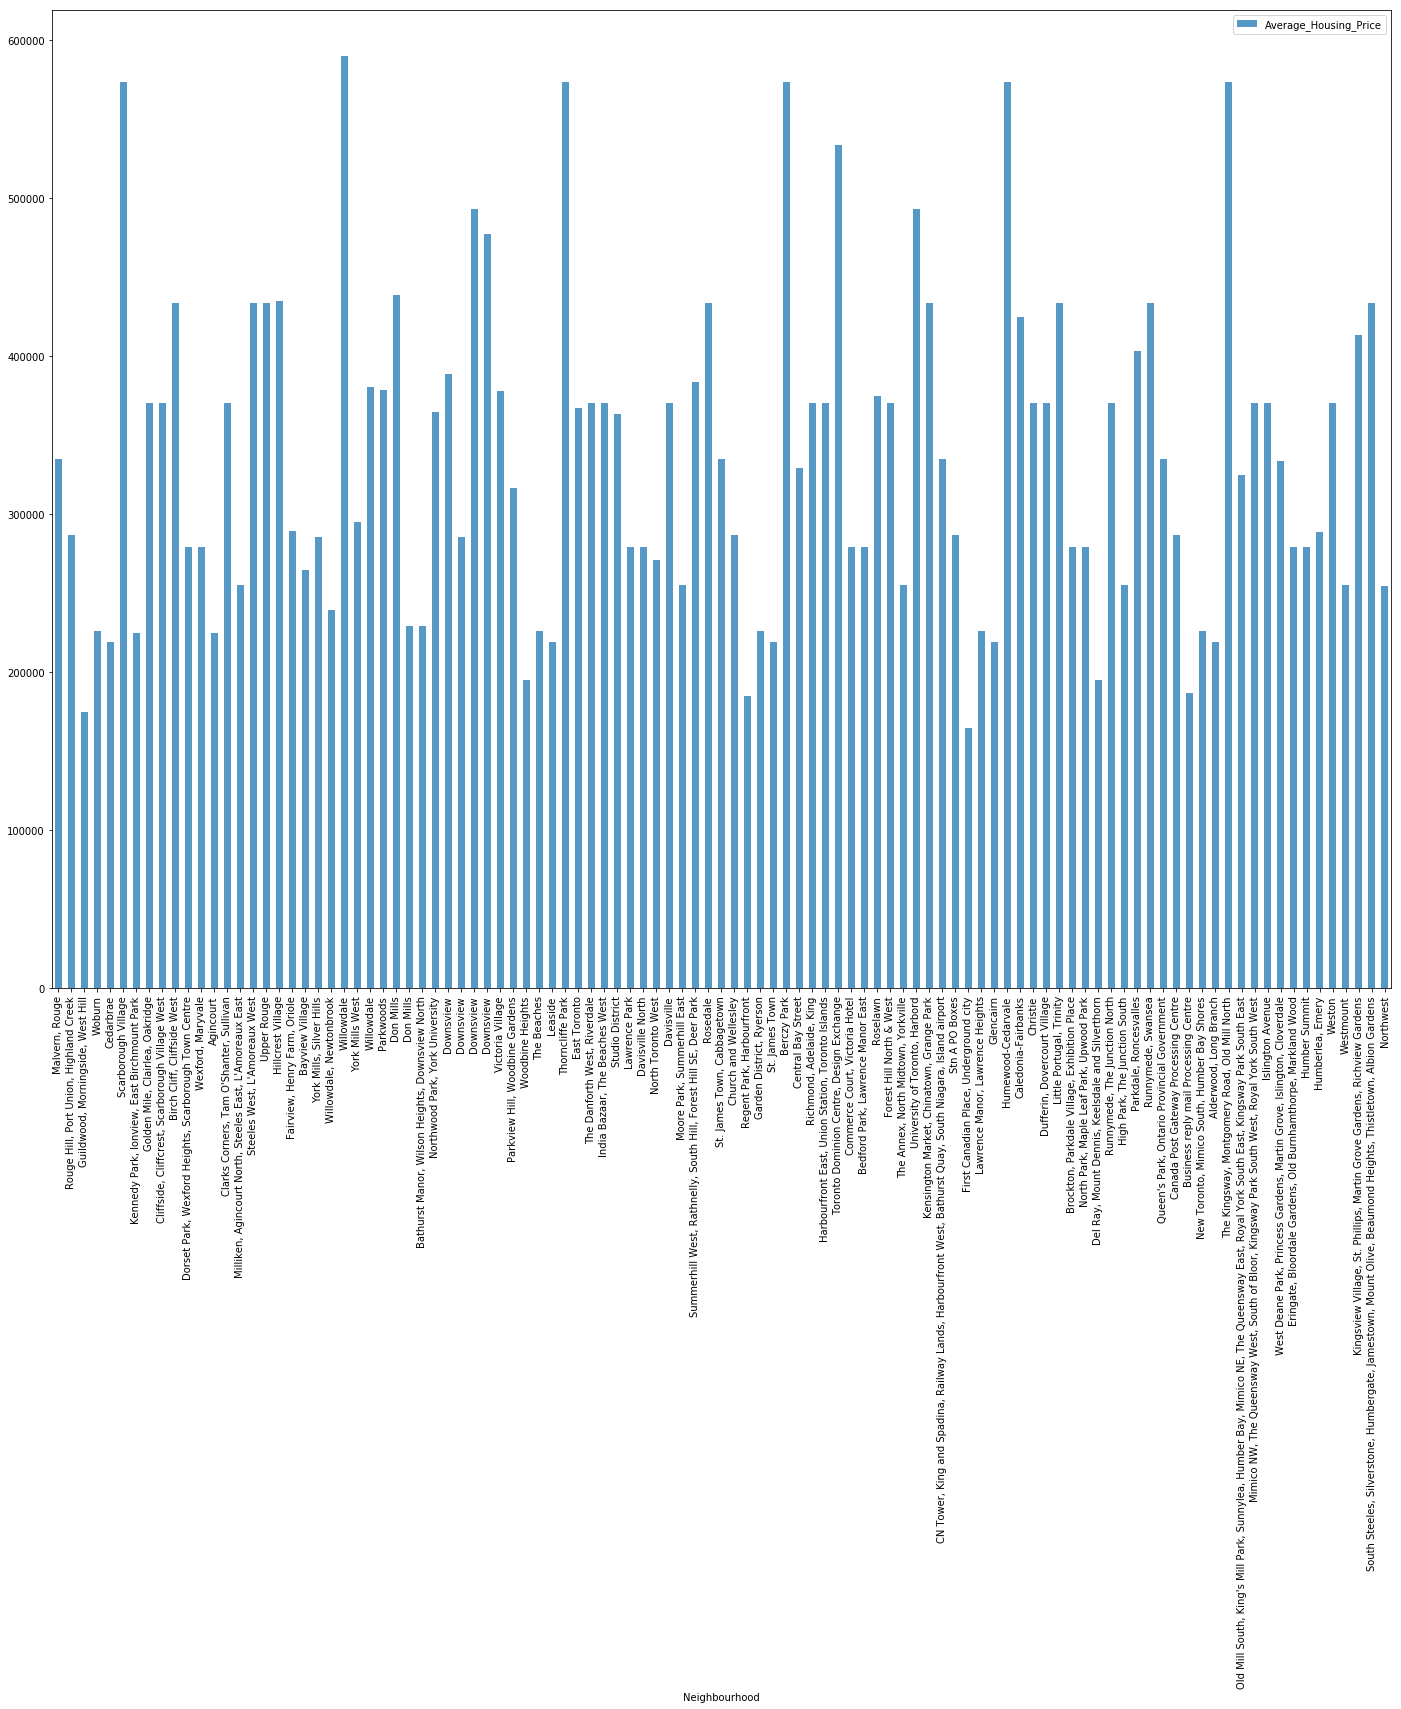

In [106]:
NY_Avg_HousingPrice.set_index('Neighbourhood',inplace=True,drop=True)

NY_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)